# EDA multi-saisons pour Machine Learning

## 1. Chargement de toutes les saisons (2014–2024)

In [1]:
import pandas as pd
from pathlib import Path

# Chemins
base = Path("../data/curated/")
seasons = [f"{y}-{str(y+1)[-2:]}" for y in range(1999, 2024)]

# Charger le fichier des scores
scores = pd.read_parquet(base / "all_seasons_scores.parquet")

# Charger toutes les saisons pour les features
dfs = []
for s in seasons:
    df = pd.read_parquet(base / f"player_season_{s}.parquet")
    df["season"] = s
    dfs.append(df)

features = pd.concat(dfs, ignore_index=True)

# Fusion des scores + features
df_all = pd.merge(scores, features, on=["PLAYER_ID", "season"], how="left")
df_all["avail"] = df_all["gp"] / 82
df_all.shape


(12101, 37)

In [2]:
# 1. Crée une seule colonne score_100
df_all["score_100"] = df_all["score_100_x"].fillna(df_all["score_100_y"])

# 2. Supprime les deux colonnes intermédiaires
df_all.drop(columns=["score_100_x","score_100_y"], inplace=True)

In [3]:
numeric_cols = [c for c in df_all.columns
                if df_all[c].dtype in ['int64','float64']
                and c not in ['PLAYER_ID','season','score_100']
               ]


## 2. Valeurs manquantes globales

In [4]:
df_all.isna().mean().sort_values(ascending=False) * 100

POSITION           12.841914
weight_kg          12.841914
fg3_pct            12.544418
ft_pct              3.991406
ast_tov_ratio       2.677465
fg2_pct             0.760268
usage_rate          0.033055
pts36               0.000000
stl_mean            0.000000
blk_mean            0.000000
tov_mean            0.000000
PLAYER_ID           0.000000
ast36               0.000000
stl36               0.000000
blk36               0.000000
tov36               0.000000
pm36                0.000000
avail               0.000000
reb36               0.000000
ts_pct              0.000000
season              0.000000
efg_pct             0.000000
pace                0.000000
TEAM_ID             0.000000
esv_mean            0.000000
exp                 0.000000
age                 0.000000
bmi                 0.000000
height_cm           0.000000
min_per_game        0.000000
gp                  0.000000
plus_minus_mean     0.000000
ast_mean            0.000000
reb_mean            0.000000
pts_mean      

## 3. Distribution des nouvelles features


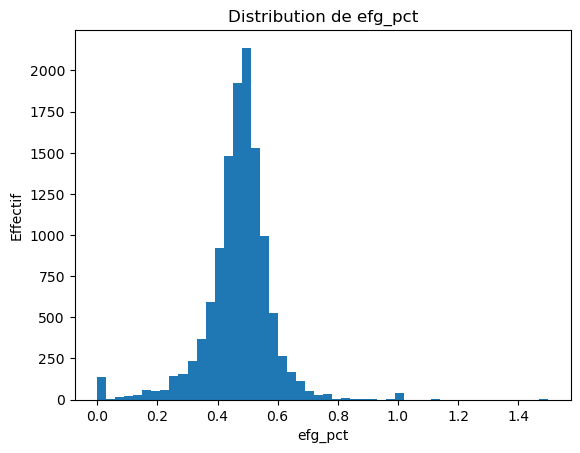

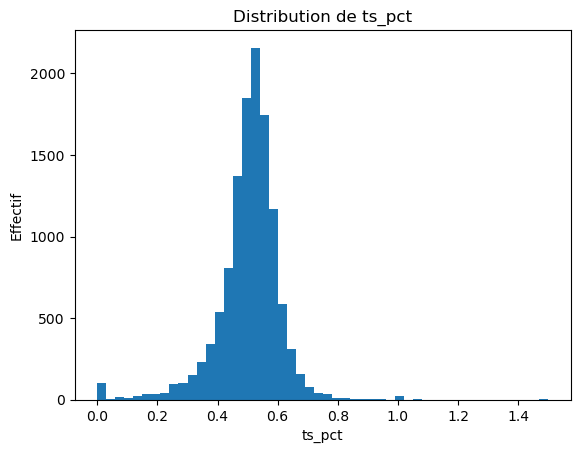

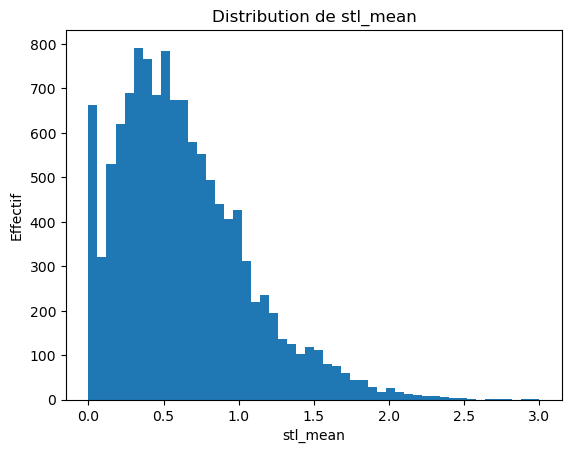

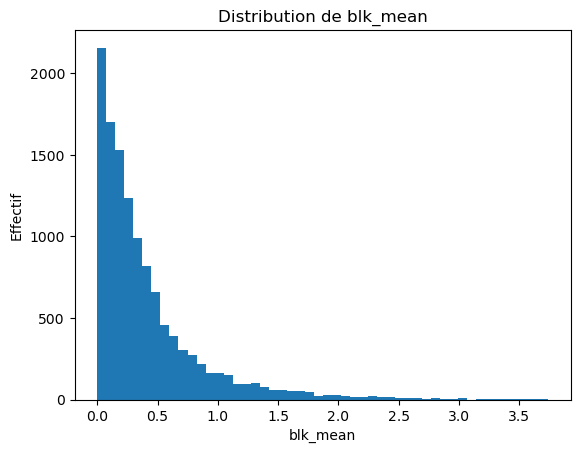

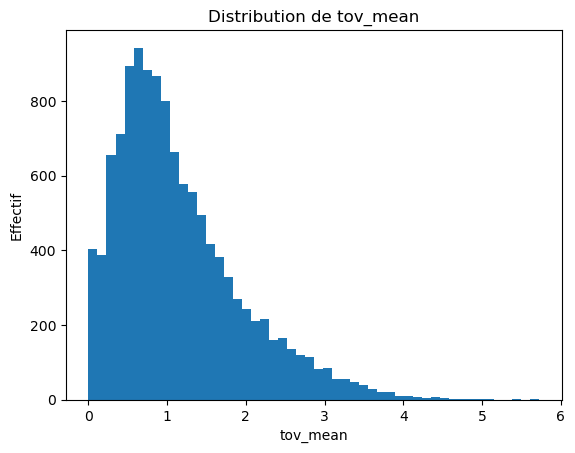

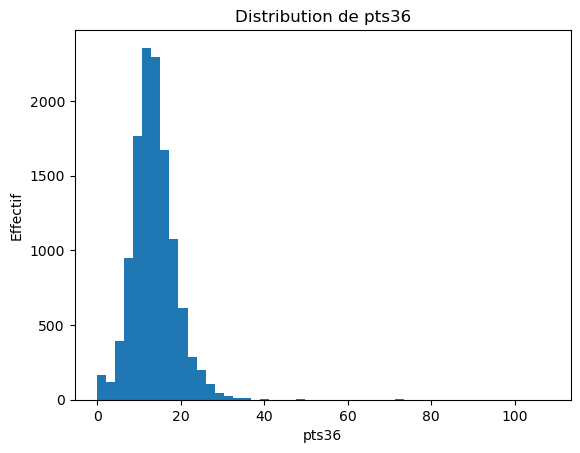

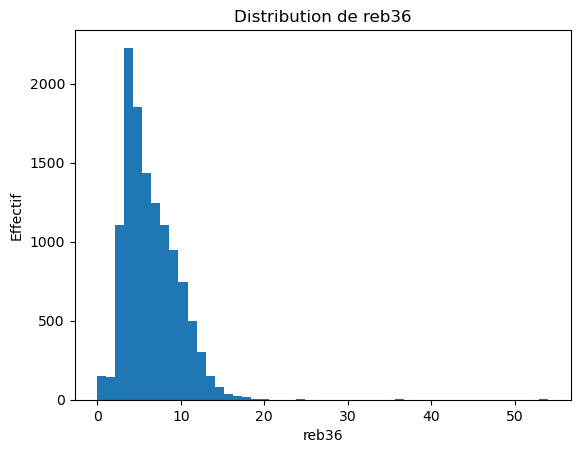

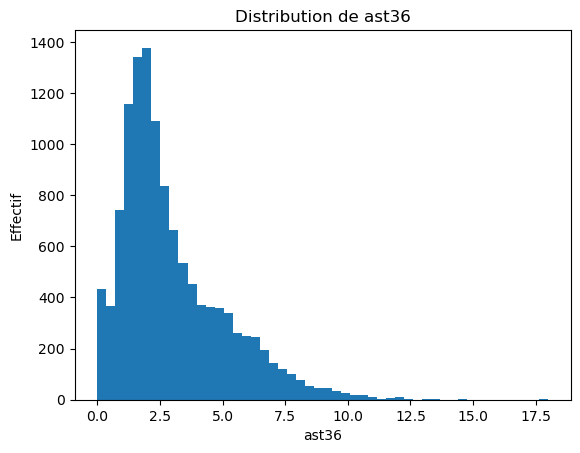

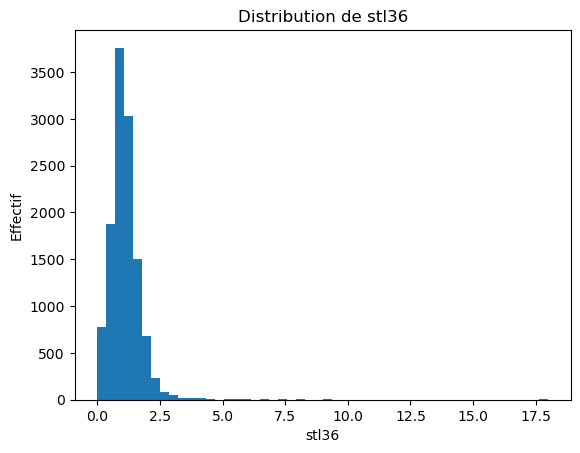

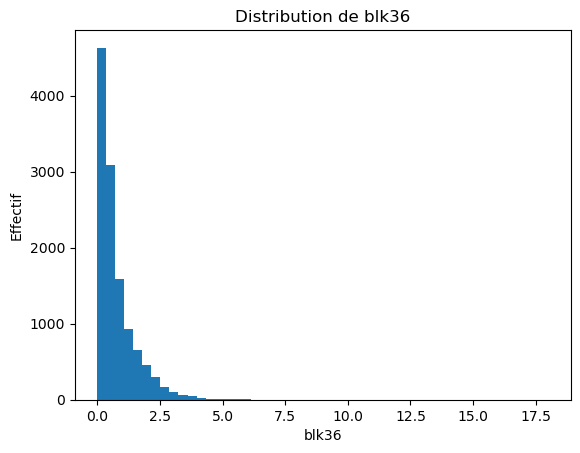

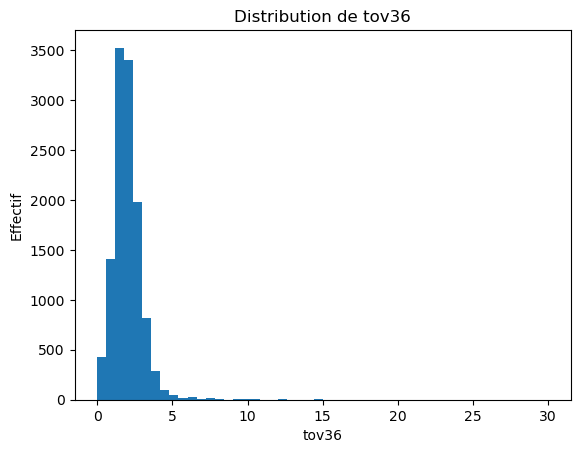

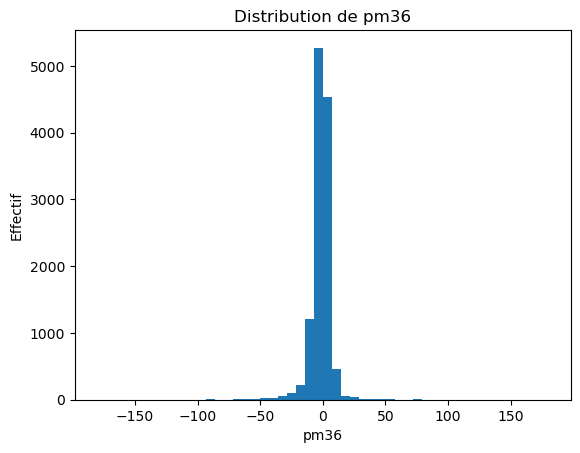

In [5]:
# On visualise la distribution de chaque feature avancée (per36, efg_pct, ts_pct, etc.)
import matplotlib.pyplot as plt

new_feats = [
    'efg_pct', 'ts_pct',
    'stl_mean', 'blk_mean', 'tov_mean',
    'pts36', 'reb36', 'ast36', 'stl36', 'blk36', 'tov36', 'pm36'
]

for feat in new_feats:
    data = df_all[feat].dropna()
    plt.figure()
    plt.hist(data, bins=50)
    plt.title(f"Distribution de {feat}")
    plt.xlabel(feat)
    plt.ylabel('Effectif')
    plt.show()

## 4. Matrice de corrélations des nouvelles features


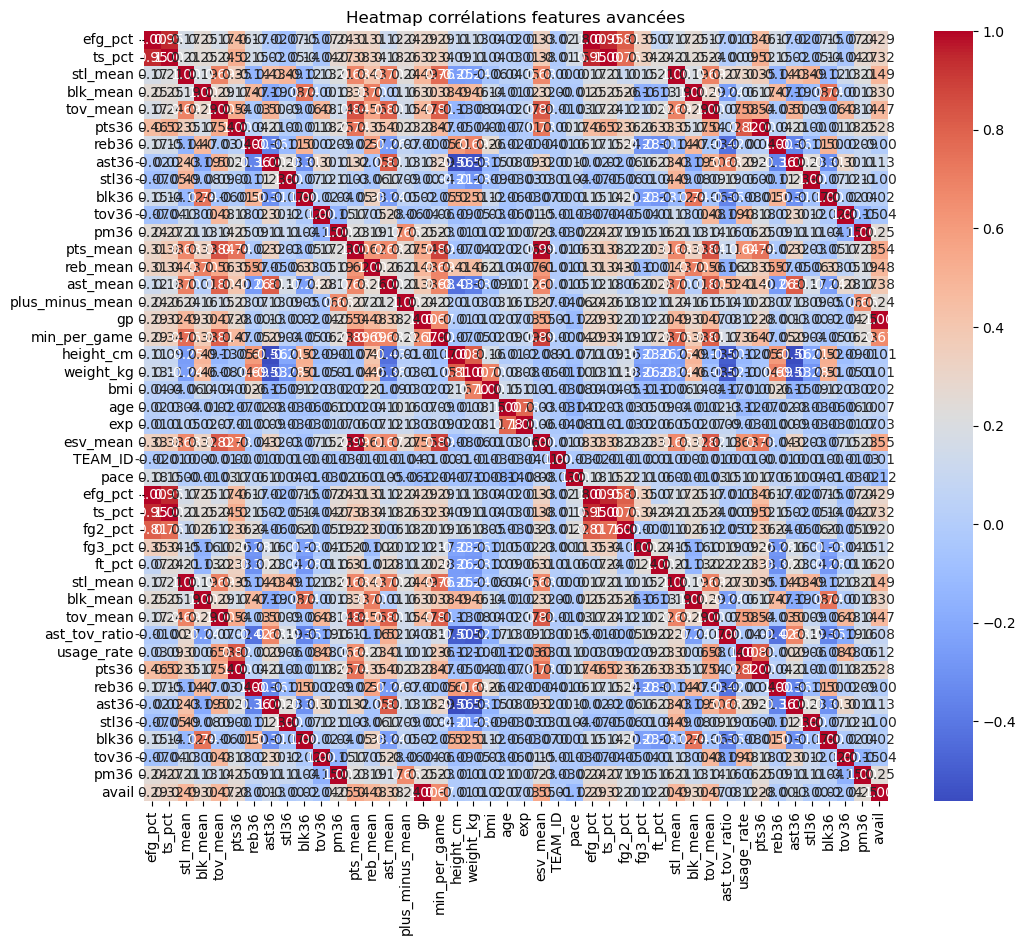

In [6]:
import seaborn as sns
corr = df_all[new_feats + numeric_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap corrélations features avancées")
plt.show()


## 4. Évolution temporelle de pts_mean

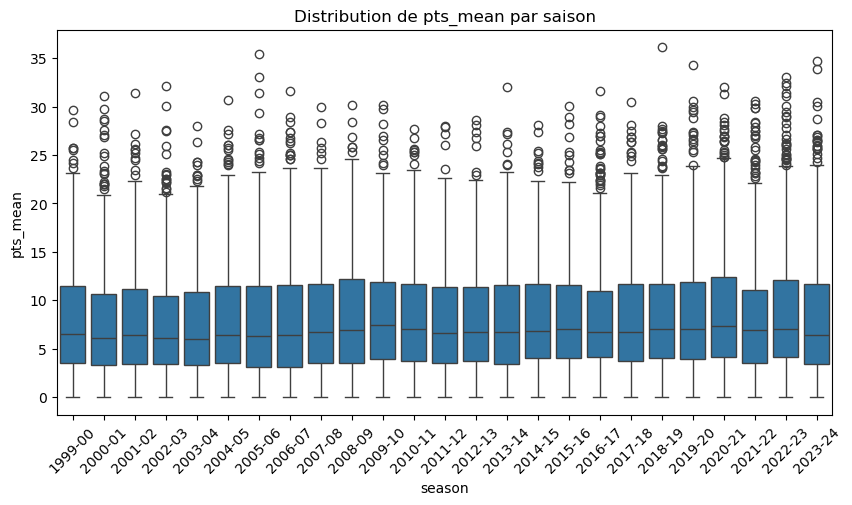

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=df_all, x='season', y='pts_mean')
plt.title("Distribution de pts_mean par saison")
plt.xticks(rotation=45)
plt.show()

## 5. Corrélations globales

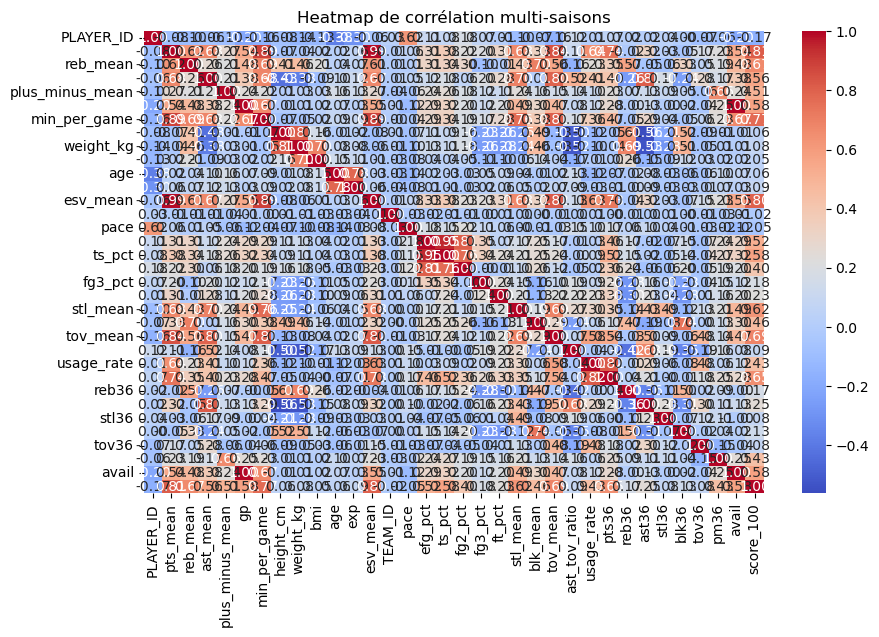

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df_all.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de corrélation multi-saisons")
plt.show()

## 6. Importance des features via Random Forest


In [9]:
from sklearn.ensemble import RandomForestRegressor
target = "score_100"
X = df_all[new_feats + numeric_cols].fillna(0)
y = df_all[target]
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
display(importances.sort_values(ascending=False)[:15])


pts_mean           0.714511
ts_pct             0.072382
ts_pct             0.072223
plus_minus_mean    0.041974
pm36               0.027747
reb_mean           0.027201
pm36               0.025679
efg_pct            0.004599
efg_pct            0.003986
esv_mean           0.001595
blk_mean           0.001555
blk_mean           0.001519
pts36              0.001220
pts36              0.000845
reb36              0.000528
dtype: float64

## 7. Analyse des outliers


In [10]:
outliers = {}
for feat in new_feats:
    mu, sigma = df_all[feat].mean(), df_all[feat].std()
    outliers[feat] = df_all[(df_all[feat]-mu).abs() > 3*sigma].shape[0]
pd.Series(outliers)


efg_pct     264
ts_pct      250
stl_mean    119
blk_mean    270
tov_mean    130
pts36        83
reb36        70
ast36       149
stl36       110
blk36       190
tov36        99
pm36        207
dtype: int64

## 7. Préparation du jeu ML : note_n → note_n+1

In [11]:
df_all = df_all.sort_values(["PLAYER_ID", "season"])
df_all["note_n"] = df_all["score_100"]
df_all["note_n1"] = df_all.groupby("PLAYER_ID")["score_100"].shift(-1)

# Seulement les lignes avec une target disponible
ml_df = df_all.dropna(subset=["note_n1"])
ml_df[["PLAYER_ID", "season", "note_n", "note_n1"]].head()

,PLAYER_ID,season,note_n,note_n1
0,3,1999-00,45.628462,42.905841
439,3,2000-01,42.905841,36.169073
880,3,2001-02,36.169073,30.281469
1,15,1999-00,45.466705,50.819439
440,15,2000-01,50.819439,50.759955


## 8. Corrélation entre saison n et saison n+1

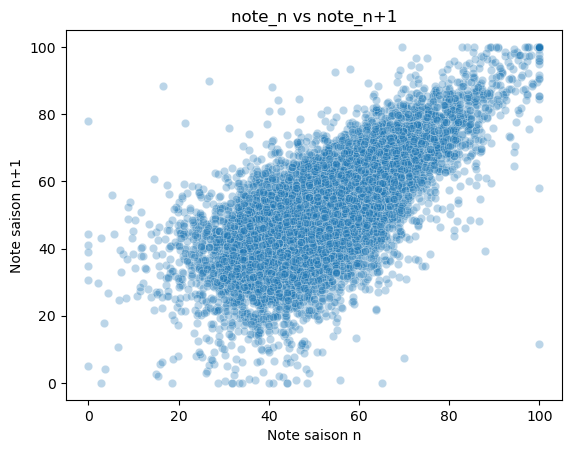

In [12]:
sns.scatterplot(data=ml_df, x="note_n", y="note_n1", alpha=0.3)
plt.title("note_n vs note_n+1")
plt.xlabel("Note saison n")
plt.ylabel("Note saison n+1")
plt.show()

## 9. Conclusion

- Variables les plus stables : `pts_mean`, `reb_mean`, `avail`, `age`
- Corrélation forte entre note_n et note_n+1 ➜ bon candidat pour prédiction
- Prochaine étape : préparer X / y pour entraîner un modèle prédictif.

## 10. Variabilité inter-joueurs (constance vs irrégularité)

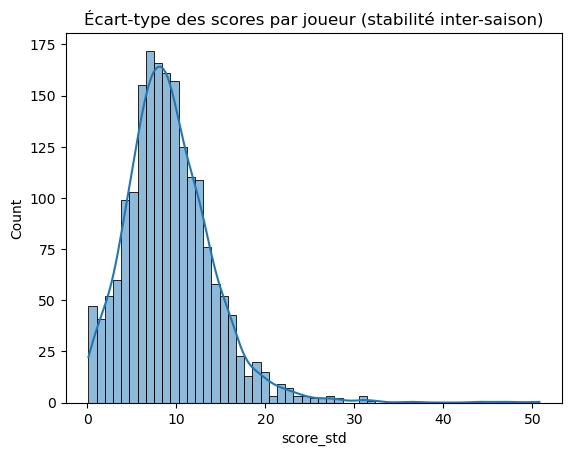

In [13]:
df_std = df_all.groupby("PLAYER_ID")["score_100"].std().reset_index()
df_std.columns = ["PLAYER_ID", "score_std"]
sns.histplot(df_std["score_std"], kde=True)
plt.title("Écart-type des scores par joueur (stabilité inter-saison)")
plt.show()

## 11. Exemple de trajectoire individuelle

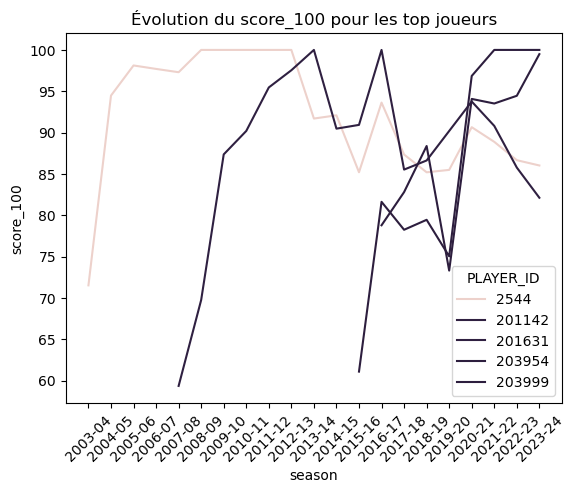

In [14]:
top_players = df_all.groupby("PLAYER_ID")["score_100"].mean().sort_values(ascending=False).head(5).index.tolist()
df_top = df_all[df_all["PLAYER_ID"].isin(top_players)]
sns.lineplot(data=df_top, x="season", y="score_100", hue="PLAYER_ID")
plt.title("Évolution du score_100 pour les top joueurs")
plt.xticks(rotation=45)
plt.show()

## 12. Stats moyennes par tranche d'âge

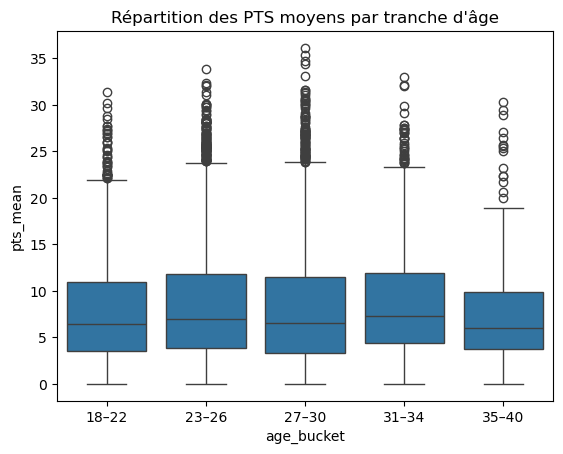

In [15]:
df_all['age_bucket'] = pd.cut(df_all['age'], bins=[18, 22, 26, 30, 34, 40], labels=["18–22","23–26","27–30","31–34","35–40"])
sns.boxplot(data=df_all, x="age_bucket", y="pts_mean")
plt.title("Répartition des PTS moyens par tranche d'âge")
plt.show()

## 13. t-SNE pour visualiser les types de profils joueurs

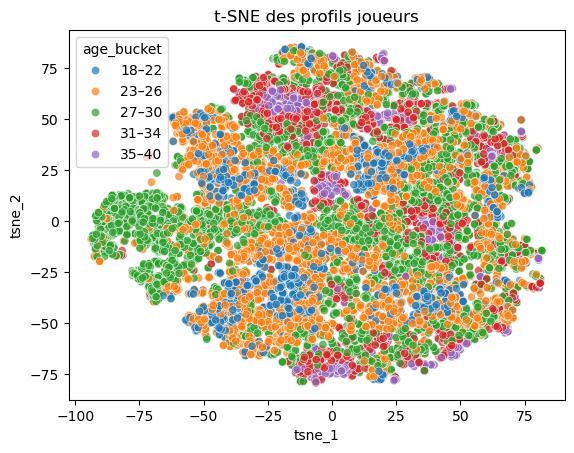

In [16]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

features = ["pts_mean", "reb_mean", "ast_mean", "plus_minus_mean", "avail", "height_cm", "bmi", "age"]
df_visu = df_all.dropna(subset=features).copy()
# Create age_bucket in df_visu similar to how it was created earlier
df_visu['age_bucket'] = pd.cut(df_visu['age'], bins=[18, 22, 26, 30, 34, 40], labels=["18–22","23–26","27–30","31–34","35–40"])

X = StandardScaler().fit_transform(df_visu[features])

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
df_visu["tsne_1"], df_visu["tsne_2"] = zip(*tsne.fit_transform(X))
sns.scatterplot(data=df_visu, x="tsne_1", y="tsne_2", hue="age_bucket", alpha=0.7)
plt.title("t-SNE des profils joueurs")
plt.show()

## 🔍 Visualisation t‑SNE des profils joueurs

Nous avons projeté les joueurs NBA sur un plan en 2D à l’aide d’un **t-SNE** (t-distributed stochastic neighbor embedding), basé sur leurs caractéristiques techniques et physiques :

- `pts_mean`, `reb_mean`, `ast_mean`, `plus_minus_mean`
- `avail` (disponibilité = GP / 82)
- `height_cm`, `bmi`, `age`

Les couleurs correspondent aux **tranches d’âge** (`age_bucket`), segmentées de 18 à 40 ans.

### 🧠 Observations :
- Une structure claire émerge : certains groupes sont **cohérents et bien séparés**.
- Les **joueurs âgés (31–34, 35–40)** sont nettement regroupés : leurs profils sont plus homogènes.
- Les **plus jeunes (18–22)** sont davantage dispersés → profils variés ou en construction.
- Le t-SNE illustre visuellement que l’**âge est une variable fortement liée au style et à la production**.

Ce graphique suggère qu’il serait intéressant de tester :
- un **clustering** type K-Means sur les mêmes données
- ou d’utiliser ces tranches d’âge comme feature catégorielle dans les modèles ML.


## 14. Conclusion approfondie

- La variabilité inter-joueur montre des profils très stables vs irréguliers.
- Les courbes temporelles confirment une forte stabilité pour les tops joueurs.
- Les tranches d’âge influencent nettement la production moyenne.
- Le t-SNE révèle des regroupements de profils cohérents.

➡️ Ces insights serviront à créer un modèle plus pertinent et à enrichir les features utilisées.

---

## 15. Clustering des profils joueurs avec K-Means

Nous allons ici utiliser l'algorithme **K-Means** pour regrouper les joueurs en **profils-types**, basés sur leurs statistiques et données physiques.
Cela permettra de créer des **archétypes** (à la manière de NBA 2K) exploitables pour le ML

Les variables utilisées sont :
- Statistiques moyennes : `pts_mean`, `reb_mean`, `ast_mean`, `plus_minus_mean`, `avail`
- Données physiques : `height_cm`, `bmi`, `age`


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Sélection des features
features = ["pts_mean", "reb_mean", "ast_mean", "plus_minus_mean", "avail", "height_cm", "bmi", "age"]
df_cluster = df_all.dropna(subset=features).copy()

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])

# Application de KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
df_cluster["player_cluster"] = kmeans.fit_predict(X_scaled)

# Nombre de joueurs par cluster
df_cluster["player_cluster"].value_counts().sort_index()


player_cluster
0    3254
1    3129
2    2318
3    1479
4    1921
Name: count, dtype: int64

In [18]:
from sklearn.manifold import TSNE

# Recalcul du t-SNE sur les données standardisées utilisées pour le clustering
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(X_scaled)

df_cluster["tsne_1"] = tsne_results[:, 0]
df_cluster["tsne_2"] = tsne_results[:, 1]


### Visualisation des clusters via t-SNE

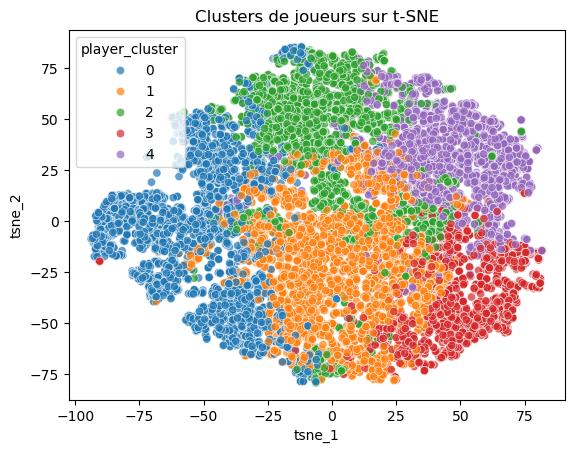

In [19]:
sns.scatterplot(data=df_cluster, x="tsne_1", y="tsne_2", hue="player_cluster", palette="tab10", alpha=0.7)
plt.title("Clusters de joueurs sur t-SNE")
plt.show()

## 16. Conclusion du clustering

- Le modèle K-Means a permis de répartir les joueurs en **5 groupes distincts**.
- Ces groupes représentent des **profils de jeu** réalistes, que l’on pourra interpréter en analysant les moyennes de chaque cluster.
- Ces clusters peuvent être :
  - Ajoutés comme **variables catégorielles** dans les modèles ML
  - Affichés dans un **dashboard interactif**
  - Nommés pour correspondre à des archétypes : *Scorer*, *Playmaker*, *Big Man*, *All-Around*, etc.

➡️ Prochaine étape : **analyser les moyennes de chaque groupe** pour leur donner une identité.


## 18. Analyse du profil moyen par cluster

In [20]:
# Analyse des profils moyens de chaque cluster
features = ["pts_mean", "reb_mean", "ast_mean", "plus_minus_mean", "avail", "height_cm", "bmi", "age"]
cluster_stats = df_cluster.groupby("player_cluster")[features].mean().round(2)
display(cluster_stats)


# Nommage des clusters après analyse
cluster_names = {
    0: "Playmaker",
    1: "Big Man",
    2: "Jeune Banc",
    3: "All-Around",
    4: "Scoring Guard"
}
df_cluster["profile_name"] = df_cluster["player_cluster"].map(cluster_names)

,pts_mean,reb_mean,ast_mean,plus_minus_mean,avail,height_cm,bmi,age
player_cluster,,,,,,,,
0,3.09,1.66,0.68,-1.28,0.23,200.82,24.62,25.34
1,8.04,2.83,1.86,-1.14,0.77,196.51,24.04,25.18
2,5.71,3.46,1.01,-0.25,0.68,205.02,25.93,30.89
3,16.68,4.04,5.44,1.72,0.82,192.08,24.53,28.03
4,14.01,7.68,2.00,0.81,0.84,207.96,25.49,26.41


In [21]:
df_cluster[["PLAYER_ID", "player_cluster", "profile_name"]].head()

,PLAYER_ID,player_cluster,profile_name
0,3,2,Jeune Banc
439,3,2,Jeune Banc
880,3,2,Jeune Banc
1320,3,0,Playmaker
1,15,1,Big Man


In [22]:
# Identifier les joueurs actifs (présents dans la saison la plus récente 2023-24)
derniere_saison = "2023-24"
joueurs_actifs = df_all[df_all["season"] == derniere_saison]["PLAYER_ID"].unique()

# Compter le nombre de saisons par joueur (parmi les joueurs actifs)
experience = df_all[df_all["PLAYER_ID"].isin(joueurs_actifs)].groupby("PLAYER_ID").agg(
    nombre_saisons=("season", "nunique"),
    age_actuel=("age", "max")
).sort_values("nombre_saisons", ascending=False)

# Afficher les 5 joueurs actifs les plus expérimentés
print("Top 5 des joueurs actifs avec le plus d'expérience:")
experience.head(5)

Top 5 des joueurs actifs avec le plus d'expérience:


,nombre_saisons,age_actuel
PLAYER_ID,,
2544,21,39.0
101108,19,39.0
200768,18,38.0
201143,17,38.0
201144,17,36.0
